In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression


sprint = pd.read_csv('cleaned_sprint_results.csv')
results = pd.read_csv('cleaned_results.csv')
drivers = pd.read_csv('cleaned_drivers.csv')
races = pd.read_csv('cleaned_races.csv')
standings = pd.read_csv('cleaned_driver_standings.csv')
constructor = pd.read_csv('cleaned_constructor_standings.csv')
seasons = pd.read_csv('cleaned_seasons.csv')

In [2]:
races_columns = races[['raceId', 'year']]
results_with_year = results.merge(races_columns, on='raceId', how='inner')

filtered_results = results_with_year[results_with_year['year'] >= 2021]
filtered_results = filtered_results[~filtered_results['raceId'].isin(sprint['raceId'])]


results_columns = filtered_results[['driverId', 'points']]
results_columns = results_columns.groupby('driverId')['points'].sum().reset_index()

drivers['driver_name'] = drivers['driver_forename'] + ' ' + drivers['driver_surname']
driver_columns = drivers[['driverId', 'driver_name']]

sprint_columns = sprint[['driverId', 'position', 'points',
                         'fastestLapTime', 'fastestLapRank', 'raceId',
                        'grid_position']].copy()
sprint_columns['fastestLapTime'] = pd.to_timedelta(sprint_columns['fastestLapTime'])
sprint_columns['fastestLapTime'] = sprint_columns['fastestLapTime'].dt.total_seconds()
sprint_columns.loc[:, 'top_3_finish'] = (sprint_columns['position'] <= 3).astype(int)
sprint_columns.loc[:, 'finished_first'] = (sprint_columns['position'] == 1).astype(int)
sprint_columns['position_change'] = sprint_columns['grid_position'] - sprint_columns['position']
sprint_columns = sprint_columns.groupby('driverId').agg(
    top_3_finish=('top_3_finish', 'sum'),
    num_finished_first=('finished_first', 'sum'),
    sprint_points=('points', 'sum'),
    avg_fastest_lap_time=('fastestLapTime', 'mean'),
    avg_fastest_lap_rank=('fastestLapRank', 'mean'),
    num_sprint_races=('raceId', 'count'),
    avg_sprint_finish=('position', 'mean'),
    avg_starting_position=('grid_position', 'mean'),
    total_position_change=('position_change', 'sum')
).reset_index()

final_df = results_columns.merge(sprint_columns, on='driverId', how='left')
final_df = final_df.merge(driver_columns, on='driverId', how='left')
final_df['top3_percent'] = final_df['top_3_finish'] / final_df['num_sprint_races']
final_df['sprint_efficiency'] = final_df['sprint_points'] / final_df['num_sprint_races']


final_df.head()

,driverId,points,top_3_finish,num_finished_first,sprint_points,avg_fastest_lap_time,avg_fastest_lap_rank,num_sprint_races,avg_sprint_finish,avg_starting_position,total_position_change,driver_name,top3_percent,sprint_efficiency
0,1,654.5,2,0,13,85.259889,6.000000,9,6.777778,9.333333,23,Lewis Hamilton,0.222222,1.444444
1,4,249.0,0,0,7,65.035556,7.888889,9,12.000000,9.111111,-26,Fernando Alonso,0.000000,0.777778
2,8,10.0,0,0,0,83.019500,14.000000,2,15.500000,15.000000,-1,Kimi Räikkönen,0.000000,0.000000
3,9,0.0,0,0,0,86.772000,19.000000,1,18.000000,19.000000,1,Robert Kubica,0.000000,0.000000
4,20,76.0,0,0,0,79.591667,13.666667,6,11.833333,12.333333,3,Sebastian Vettel,0.000000,0.000000


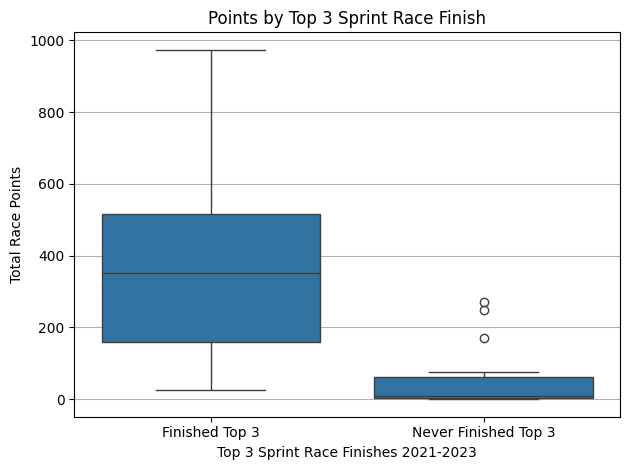

In [3]:
boxplot_df = final_df.copy()
boxplot_df['top_3_finish'] = (boxplot_df['top_3_finish'] >= 1).astype(int)
boxplot_df['Top 3 Sprint Finish'] = boxplot_df['top_3_finish'].map({
    0: 'Never Finished Top 3',
    1: 'Finished Top 3'
})

sns.boxplot(data=boxplot_df, x='Top 3 Sprint Finish', y='points')
plt.title('Points by Top 3 Sprint Race Finish')
plt.xlabel('Top 3 Sprint Race Finishes 2021-2023')
plt.ylabel('Total Race Points')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [4]:
plot_df = final_df.copy()

num_top_3 = [
    plot_df['top_3_finish'] == 0,
    plot_df['top_3_finish'] == 1,
    plot_df['top_3_finish'] >= 2
]

labels = ['0 Top 3 Finishes', '1 Top 3 Finish', '2+ Top 3 Finishes']

plot_df['sprint_win_group'] = np.select(num_top_3, labels)

plot_df = plot_df.groupby('sprint_win_group')['points'].mean().reset_index()

plt.bar(plot_df['sprint_win_group'], plot_df['points'], color='cornflowerblue')
plt.title('Average Points by Sprint Race Wins')
plt.xlabel('Number of Top 3 Sprint Finishes')
plt.ylabel('Average Points')
plt.grid(axis='y')
plt.show()

TypeError: Choicelist and default value do not have a common dtype: The DType <class 'numpy.dtypes._PyLongDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes._PyLongDType'>)

In [5]:
standings.head()

,driverStandingsId,raceId,driverId,points,position,wins
0,1,18,1,10.0,1,1
1,2,18,2,8.0,2,0
2,3,18,3,6.0,3,0
3,4,18,4,5.0,4,0
4,5,18,5,4.0,5,0


In [6]:
X = final_df[[]]

In [7]:
X = final_df[['top_3_finish', 'num_sprint_races',
              'avg_fastest_lap_rank', 'avg_sprint_finish', 'total_position_change',
             ]]
y = final_df['points']
X = sm.add_constant(X)

model = sm.OLS(y,X).fit()
results = model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     24.02
Date:                Mon, 12 May 2025   Prob (F-statistic):           3.14e-08
Time:                        21:19:58   Log-Likelihood:                -166.57
No. Observations:                  28   AIC:                             345.1
Df Residuals:                      22   BIC:                             353.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    69.3162    146.324      0.474      0.640    -234.141     372.773
top_3_finish             84.1763     17.006      4.950      0.000      48.908     119.444
num_sprint_races         21.5637      9.579      2.251      0.035       1.699      41.428
avg_fastest_lap_rank    -10.7836      9.612     -1.122      0.274     -30.718       9.151
avg_sprint_finish         0.4936     11.777      0.042      0.967     -23.931      24.918
total_position_change     1.2840      2.049      0.627      0.537      -2.965       5.533
==============================================================================
Omnibus:                        1.769   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.413   Jarque-Bera (JB):                0.834
Skew:                           0.396   Prob(JB):                        0.659
Kurtosis:                       3.294   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

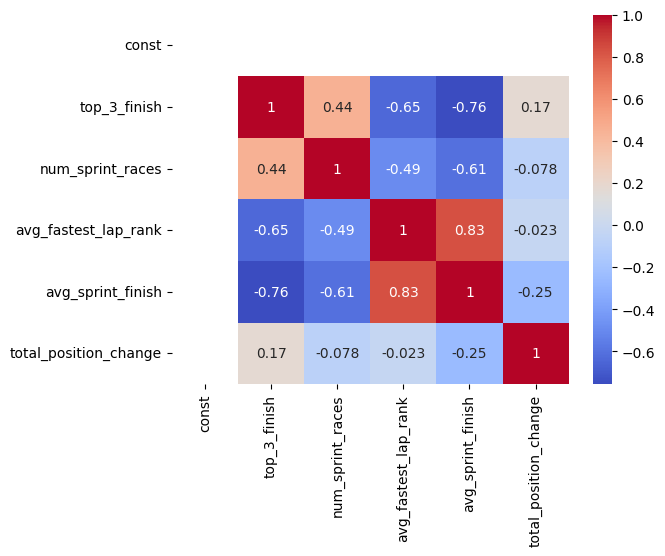

In [8]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

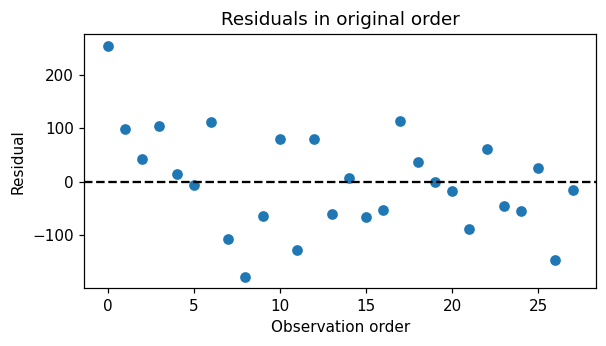

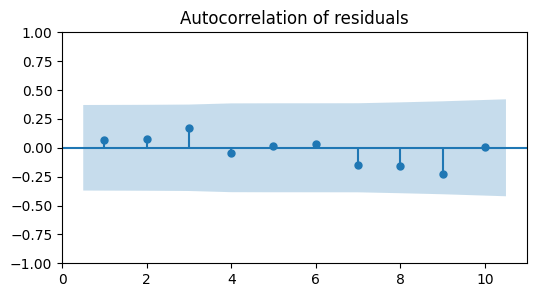

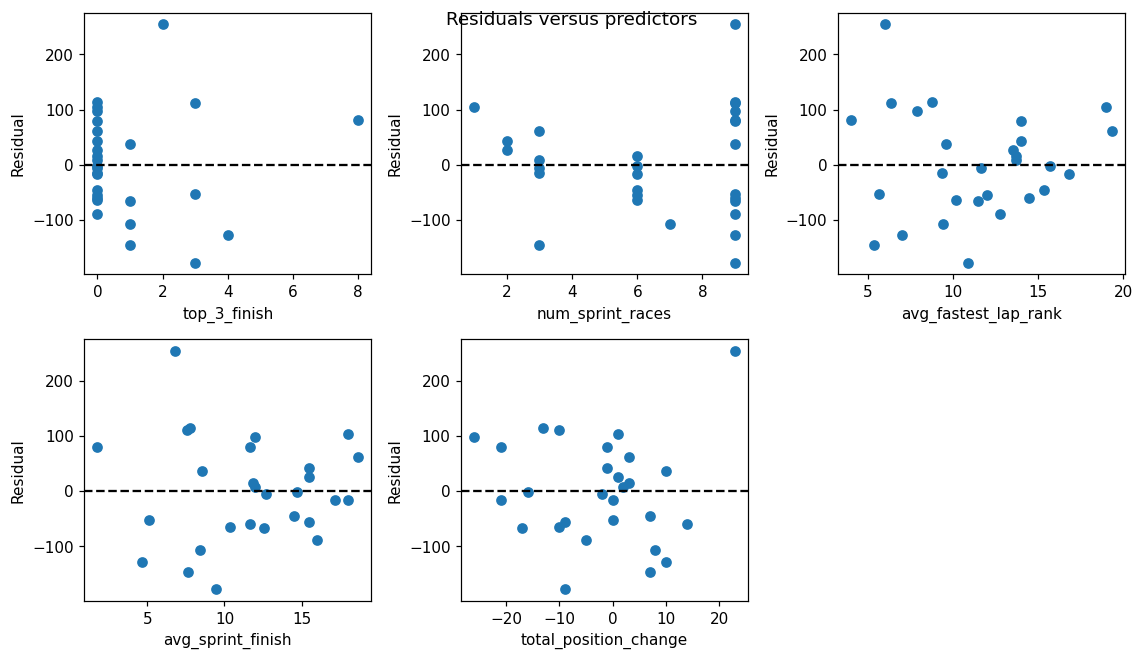

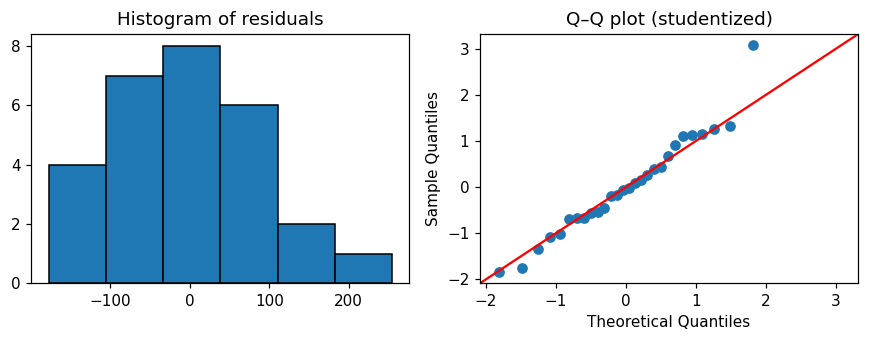

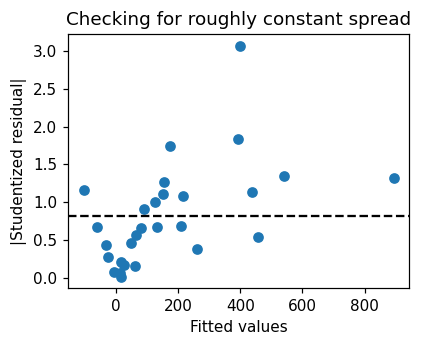

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

resid = model.resid
fitted = model.fittedvalues
std_resid = model.get_influence().resid_studentized_internal
X = model.model.exog
predictors = model.model.exog_names[1:]


fig, ax = plt.subplots(figsize=(6,3), dpi=110)
ax.scatter(np.arange(len(resid)), resid)
ax.axhline(0, ls='--', c='k')
ax.set_xlabel("Observation order")
ax.set_ylabel("Residual")
ax.set_title("Residuals in original order")
plt.show()

plot_acf(resid, lags=10, zero=False)
plt.gcf().set_size_inches(6,3)
plt.title("Autocorrelation of residuals")
plt.show()

n_cols = 3
n_rows = int(np.ceil(len(predictors)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols*3.5, n_rows*3.2),
                         squeeze=False, dpi=110)
axes = axes.flatten()
for i, p in enumerate(predictors):
    axes[i].scatter(X[:, i+1], resid)
    axes[i].axhline(0, ls='--', c='k')
    axes[i].set_xlabel(p)
    axes[i].set_ylabel("Residual")
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle("Residuals versus predictors", y=0.93)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3.2), dpi=110)
ax[0].hist(resid, bins="auto", edgecolor='k')
ax[0].set_title("Histogram of residuals")
sm.qqplot(std_resid, line='45', ax=ax[1])
ax[1].set_title("Q–Q plot (studentized)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,3), dpi=110)
plt.scatter(fitted, np.abs(std_resid))
plt.axhline(np.abs(std_resid).mean(), ls='--', c='k')
plt.xlabel("Fitted values")
plt.ylabel("|Studentized residual|")
plt.title("Checking for roughly constant spread")
plt.show()
